## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [4]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [7]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [8]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [9]:
# When to use mean/median imputation -- No more than 5% of the variable contains missing data
# Therefore, will check the percentage of missing data in the columns    
result = X_train.isnull().mean().sort_values(ascending=False)
# print(result)

for i in range(len(result.index)):
    var = result.index[i]
    if var in numerical:
        var_type = "numerical"
    elif var in discrete:
        var_type = "discrete"
    elif var in year_vars:
        var_type = "year_vars"
    elif var in categorical:
        var_type = "categorical"
    print(f"{var} in {var_type} with {result.values[i]}")

PoolQC in categorical with 0.9954337899543378
MiscFeature in categorical with 0.9611872146118722
Alley in categorical with 0.9383561643835616
Fence in categorical with 0.8143074581430746
FireplaceQu in categorical with 0.4726027397260274
LotFrontage in numerical with 0.17732115677321156
GarageCond in categorical with 0.0563165905631659
GarageQual in categorical with 0.0563165905631659
GarageType in categorical with 0.0563165905631659
GarageYrBlt in year_vars with 0.0563165905631659
GarageFinish in categorical with 0.0563165905631659
BsmtFinType2 in categorical with 0.02511415525114155
BsmtExposure in categorical with 0.02511415525114155
BsmtQual in categorical with 0.0243531202435312
BsmtCond in categorical with 0.0243531202435312
BsmtFinType1 in categorical with 0.0243531202435312
MasVnrArea in numerical with 0.0045662100456621
MasVnrType in categorical with 0.0045662100456621
Electrical in categorical with 0.00076103500761035
ExterQual in categorical with 0.0
YearBuilt in year_vars w

In [14]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    # Adding this missing column made no major improvements to the model performance
    # ('missing_ind', mdi.AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    # Impute categorical variables with value "Missing"
    #('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),
    
    # Will impute categorical variables with most frequent category, but adding additional
    # column stating if the variable had originally a missing value or not
    ('missing_ind_categorical', mdi.AddNaNBinaryImputer(variables=categorical)),
    ('imputer_cat', mdi.FrequentCategoryImputer(variables=categorical)),
    
    # categorical encoding - section 6
    # Decreased the tolerance for rare labels to half the default value
    # Better results when encoding for both categorical and discrete variables
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.025, n_categories=10, variables=categorical+discrete)),
    ('categorical_enc',
     ce.OneHotCategoricalEncoder(top_categories=10, variables=categorical+discrete)),
    
    # ce.OrdinalCategoricalEncoder(encoding_method='ordered', variables=categorical + discrete)),

    # discretisation + encoding - section 8
    # ('discretisation', dsc.EqualFrequencyDiscretiser(q=5, return_object=True, variables=numerical)),
    # ('encoding', ce.OrdinalCategoricalEncoder(encoding_method='ordered', variables=numerical)),
    
    # Concerning numerical variables, note that we have no more imputation to do (only numerical variables
    # with missing data are 'LotFrontage' and 'MasVnrArea'), therefore we will only do feature scaling

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [15]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

/home/jpleitao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52922465997.211395, tolerance: 820439508.5822281
  positive)


In [21]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

# Original results:
# train mse: 1035269885.2749033
# train rmse: 32175.610099497775
# train r2: 0.8341931836507989

# test mse: 2006905385.1371987
# test rmse: 44798.49757678486
# test r2: 0.7079639526659387

train mse: 378408133.3428208
train rmse: 19452.715320561827
train r2: 0.9393948874949101

test mse: 1033402972.8698695
test rmse: 32146.585710925345
test r2: 0.8496237432341369


Text(0, 0.5, 'Predicted Price')

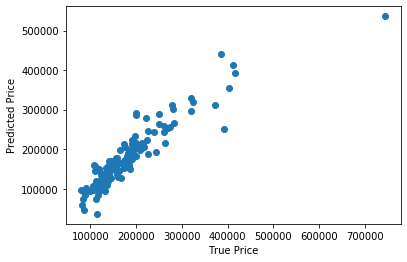

In [17]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')